In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from IPython.display import display

In [2]:
TARGET_COLUMN = 'target'
METAINFO_COLUMNS = ['stage', 'move_count', 'weight']
METAINFO_COLUMNS_COUNT = len(METAINFO_COLUMNS)
STAGE_INDEX = 0
MOVE_COUNT_INDEX = 1
WEIGHT_INDEX = 2
TARGET_INDEX = -1

STARTPOS_STAGE = 24
INPUT_LAYER_SIZE = 64 * 12

BATCH_SIZE = 32768
APPROXIMATE_TRAIN_SIZE = 0.95

In [3]:
dataset = np.zeros((0, INPUT_LAYER_SIZE + METAINFO_COLUMNS_COUNT + 1), np.int8)
for chunk in tqdm(pd.read_csv('/home/wind-eagle/quirky_data/dataset/01.csv', chunksize=125000)):
    dataset = np.append(dataset, chunk.values.astype(np.int8), axis=0)

np.random.shuffle(dataset)
train_data_size = int(dataset.shape[0] * APPROXIMATE_TRAIN_SIZE) // BATCH_SIZE * BATCH_SIZE
epoch_size = train_data_size // BATCH_SIZE

print(f'Dataset size = {dataset.shape[0]}, Test size = {dataset.shape[0] - train_data_size}, Batches in epoch: {epoch_size}')

0it [00:00, ?it/s]

18it [01:03,  3.55s/it]


Dataset size = 2153000, Test size = 121384, Batches in epoch: 62


In [4]:
class ClippedReLU(nn.Module):
    def __init__(self, clip_value: float):
        super(ClippedReLU, self).__init__()
        self.clip_value = clip_value

    def forward(self, x):
        return torch.clamp(x.relu(), max=self.clip_value)

In [5]:
class QNNE(nn.Module):
    def __init__(self):
        super(QNNE, self).__init__()

        self.feature = nn.Sequential()
        self.main = nn.Sequential()

        self.feature.add_module('linear', nn.Linear(INPUT_LAYER_SIZE, 32))
        self.feature.add_module('clipped_relu', ClippedReLU(1.0))

        self.main.add_module('first', nn.Linear(64, 1))
        self.main.add_module('sigmoid', nn.Sigmoid())

        self.xor_indices = np.zeros(INPUT_LAYER_SIZE)
        for i in range(INPUT_LAYER_SIZE):
            self.xor_indices[i] = (i % 64) ^ 56 + (i // 64) * 64

    def forward(self, x):
        return self.main(torch.cat((self.feature(x[:, METAINFO_COLUMNS_COUNT:METAINFO_COLUMNS_COUNT + 64 * 12]),\
                                    self.feature(torch.cat((x[:, METAINFO_COLUMNS_COUNT + 64 * 6:METAINFO_COLUMNS_COUNT + 64 * 12],\
                                    x[:, METAINFO_COLUMNS_COUNT:METAINFO_COLUMNS_COUNT + 64 * 6]), dim=1)[:, self.xor_indices])), dim=1))[:, 0]


In [6]:
def get_loss(model, X, y, w):
    y = (y + 1.0) / 2
    y_pred = model(X)
    assert y_pred.dim() == 1
    loss = torch.sum(w * ((y - y_pred) ** 2)) / torch.sum(w)
    return loss

In [7]:
plt.rcParams.update({ 'figure.facecolor': 'black', 'axes.facecolor': 'black', 'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white' })

In [8]:
def train_model(model, opt, scheduler, lr_limit):    
    fig = plt.figure()
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)
    train_plot_data_x, train_plot_data_y, test_plot_data_y = [], [], []
    axes.plot(train_plot_data_x, train_plot_data_y)
    fig.canvas.draw()
    hfig.update(fig)

    X_test_batch = torch.tensor(dataset[train_data_size:], dtype=torch.float32)
    y_test_batch = torch.tensor(dataset[train_data_size:, TARGET_INDEX], dtype=torch.float32)
    w_test_batch = torch.tensor(dataset[train_data_size:, WEIGHT_INDEX], dtype=torch.float32)

    epoch_num = 0
    with tqdm() as progress:
        while True:
            if opt.param_groups[0]["lr"] + 1e-9 < lr_limit:
                break
            history = []
            np.random.shuffle(dataset[:train_data_size])
            for j in range(epoch_size):
                X_batch = torch.tensor(dataset[j * BATCH_SIZE : (j + 1) * BATCH_SIZE], dtype=torch.float32)
                y_batch = torch.tensor(dataset[j * BATCH_SIZE : (j + 1) * BATCH_SIZE, TARGET_INDEX], dtype=torch.float32)
                w_batch = torch.tensor(dataset[j * BATCH_SIZE : (j + 1) * BATCH_SIZE, WEIGHT_INDEX], dtype=torch.float32)
                loss = get_loss(model, X_batch, y_batch, w_batch)

                loss.backward()
                
                opt.step()
                opt.zero_grad()

                with torch.no_grad():
                    model.main.first.weight.data = torch.clamp(model.main.first.weight.data, min=-128.0 / 64.0, max=127.0 / 64.0)

                history.append(loss.data.numpy())
            
            train_loss = sum(history) / epoch_size
            test_loss = get_loss(model, X_test_batch, y_test_batch, w_test_batch)

            scheduler.step(test_loss)

            train_plot_data_x.append(epoch_num)
            train_plot_data_y.append(train_loss)
            test_plot_data_y.append(test_loss.detach().numpy())

            axes.cla()
            axes.plot(train_plot_data_x[-50:], train_plot_data_y[-50:])
            axes.plot(train_plot_data_x[-50:], test_plot_data_y[-50:])
            fig.canvas.draw()
            hfig.update(fig)

            epoch_num += 1
            progress.update(1)
            progress.set_description(f'Average batch loss = {train_loss:.6f}, test loss = {test_loss:.6f}, lr = {opt.param_groups[0]["lr"]:.6f}')


In [9]:
def print_weights(f, arr):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            print("{0:0.5f}".format(arr[i][j]), ' ', file=f, sep="", end="")

def print_biases(f, arr):
    for i in range(arr.shape[0]):
            print("{0:0.5f}".format(arr[i]), ' ', file=f, sep="", end="")

def print_model(model, name):
    with open(name, 'w') as f:
        feature_transformer_weights = model.feature.linear.weight.T.detach().numpy()
        feature_transformer_biases = model.feature.linear.bias.detach().numpy()
        print_weights(f, feature_transformer_weights)
        print_biases(f, feature_transformer_biases)
        print_weights(f, model.main.first.weight.T.detach().numpy())
        print_biases(f, model.main.first.bias.detach().numpy())

In [10]:
import gc
gc.collect()
model = QNNE()

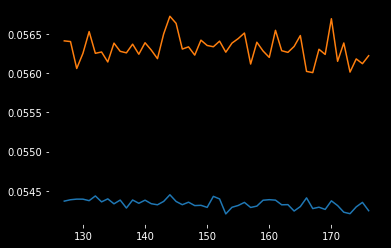

Average batch loss = 0.054249, test loss = 0.056221, lr = 0.004642: : 177it [36:29, 12.37s/it]


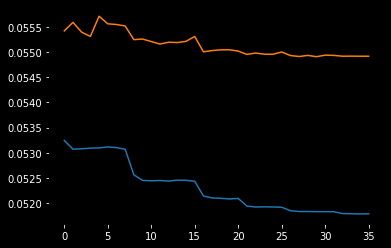

Average batch loss = 0.051787, test loss = 0.054918, lr = 0.000046: : 36it [08:30, 14.17s/it]


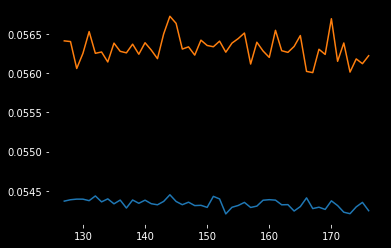

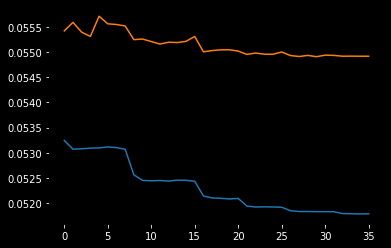

In [11]:
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-6)
scheduler = ReduceLROnPlateau(opt, patience=50, factor=np.cbrt(0.1))
train_model(model, opt, scheduler, 0.01)
scheduler = ReduceLROnPlateau(opt, patience=3, factor=np.cbrt(0.1))
train_model(model, opt, scheduler, 0.0001)

In [ ]:
print_model(model, 'model.qnne')